*11 Jan 2025, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 3301 "Data Analysis in Ocean Sciences" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/academic-notes/tree/master/OCES3301_data_analysis_ocean) page.

In [1]:
# you probably need this to if you run things in Colab (it is a bit slow to download by the way...)
#!pip install cartopy  # Colab give me version "0.19.0.post1" it would seem

# load some deafult packages
%matplotlib inline

import matplotlib.pyplot as plt
# plt.xkcd() # xkcd default formatting; comment this if you don't want it
import numpy as np
import xarray as xr
import fsspec
import copy
from scipy import signal
from scipy import interpolate
from sklearn.decomposition import PCA  # not loading the StandardScaler here because it seems to screw it up...?

# some modules for cartopy (I used 0.18.0 apparently, from "cartopy.__version__")
# download cartopy not found
try:
  import cartopy
except ModuleNotFoundError:
  !pip install cartopy
  import cartopy

import cartopy.crs as ccrs  # crs = co-ordinate reference system, for the different map projections
# some extra bits to modify the labels, lines and for making coluorbars
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable

# pull files from the internet if needed (e.g. temporary session in Colab)
# !wget https://github.com/julianmak/OCES3301_data_analysis/raw/main/salinity_WOA13_decav_Reg1L46_clim.nc
# !wget https://github.com/julianmak/OCES3301_data_analysis/raw/main/temperature_WOA13_decav_Reg1L46_clim.nc
# !wget https://github.com/julianmak/OCES3301_data_analysis/raw/main/gebco_bathy_coarsen.nc

---------------------------

# 10: Fun with maps

Lets try and draw some stuff on maps. While the data I've provided are in regular lon/lat grids so there is no strong need to use map projections, I do not provide masks or the like to plot land with, so it might be advantageous to have a package that can plot land features, coastlines and the like. You might want to focus on the poles, which the regular lon/lat projection will not be that sensible (because you are really trying to represent a disk as a cylinder, which involves a tear). There might be times when you want certain properties that simply cannot be represented in the regular lon/lat projection: for example, the area is not preserved, so giving rise to the problem that things at the equator look much smaller than they are than at the poles (e.g. Indian looks much smaller than Greenland, when actually the area is actually 1.5 times larger).

Before we get to the `cartopy` package that does most of the heavy lifting for us, just a bit of (probably) useful mathematical background.

> ## Key Objective(s)
> 1. Introduce some aspects fo cartopgraphy.
> 2. Use of the `cartopy` package for data transformation.
> 3. Perform interpolation and/or extrapolation with multi-dimensional array data.
> 4. Highlight links between Empirical Orthogonal Functions (EOFs) and PCA, and perform EOF analysis for spatial data.

## Classical geometry (with some topology)

Recall in `08_time_series` I floated the idea of a basis, where a vector can be represented in different ways (with the standard canonical basis $\{\boldsymbol{e}_1, \boldsymbol{e}_2\} = \{(1, 0), (0, 1)\}$, or some other way basis; see example in that notebook). Similarly, we can represent positions in different ways: $(1, 1)$ could be represented as the point $x=1$ and $y=1$, but I could also represent it as $r=\sqrt{2}$ and $\theta=\pi/4$, where

\begin{equation*}
    x = r\cos\theta, \qquad y = r\sin\theta,
\end{equation*}

where $\theta$ is the angle I measure from the $x$-axis, and $r$ is the radius from the origin. This is essentially a change from **Cartesian co-ordinates** to **polar co-ordinates**, and the rule give about is a **co-ordinate transformation** from $(r,\theta)$ to $(x,y)$. See drawing below.

> NOTE: In fact it is customary to teach about co-ordinate transforms before bases.

> NOTE: A co-ordinate transformation should strictly be reversible and one-to-one. The above fails at the isolated point $r=0$ corresponding to $(x,y)=(0,0)$, since I can choose any $\theta$ I like there, so we have no uniqueness, but that can be manually patched out, so it can be regarded as a co-ordinate transformation.

<img src="https://i.imgur.com/VFzpEO2.png" width="400" alt='cursed coordinate'>

Again, there is nothing particularly mysterious about this, it's just representing things in a different (and perhaps more natural) way. For example, the function corresponding to the circle of radius one in Cartesian co-ordinates is (trust me on this, or try this yourselves with some coding)

\begin{equation*}
    y = \pm \sqrt{1 - x^2}
\end{equation*}

for $x$ running from $-1$ to $1$ (and you need the plus or minus to try the two segments separately). On the other hand, in polar co-ordinates this is simply

\begin{equation*}
    r = 1
\end{equation*}

for $\theta$ running from $0$ to $2\pi$.

The problem is particularly notable if you are talking about data on a sphere. If you are on the surface of the sphere, generically you will have to specify a ($x,y,z$), but if you take for example **spherical co-ordinates** ($r, \theta, \phi$), which corresponds here respectively to radius, longitude and latitude, then if we are on the surface of the Earth, then we set $r = R_{\rm Earth}$, and we are only left with longitude and latitude, i.e. we need to carry one less variable around. If we only have two variables, then you can represent it as a 2d plot, which is of course easier (cf. `04_multilinear_regression`, where you use a PCA to get lower dimensional data).

> NOTE: I'll leave you to look up the transformation rules between Cartesian and spherical co-ordinates. You will need this if you need to compute the **metric** terms to get **distances**, which is part of some extended exercises here and in the previous notebook.

In principle you can plot data gridded at lon/lat as a flat 2d, but there is a fundamental limitation: the surface of the sphere (a 2-sphere or $S^2$) is fundamentally different to that of the plane, since the former is clearly curved while the other is flat. What this means is that the *topology* is fundamentally different (in this case through the Euler characteristic, which is related to the *Gaussian curvature* through the [Gauss-Bonnet theorem](https://en.wikipedia.org/wiki/Gauss%E2%80%93Bonnet_theorem); not going to elaborate on that). Topology is perhaps best explained through the classic example of a (cursed?) spherical cow and coffee cup / doughtnut:

<img src="https://upload.wikimedia.org/wikipedia/commons/2/24/Spot_the_cow.gif?20211112013016" width="200" alt='cursed cow'><img src="https://c.tenor.com/W13M_b0FkVMAAAAd/topology-cup.gif" width="200" alt='coffee cup'>

Here we can smoothly deform the cow into the sphere, and the cup into the doughnut, without "tearing" the surface. In that sense, they are topologically equivalent, and the cow is topologically distinct to the doughnut (the topological quantity here is the *genus*, which you could think of as "holes").

Going back to the sphere case which is our main interest, since the sphere is topologically distinct to the plane, you have to introduce a "tear" to deform the sphere onto the plane (you actually only need to remove one point). The practical consequence here is that there is ***no way to preserve both areas and angles when doing planar map projections of spherical data***. You can mathematically prove this; there is no *isometry* (a distance preserving map) between the sphere and the Cartesian plane. What this means is any map projection you make you can:

1) preserve angles (*conformal mapping*; e.g. Mercator, Lambert Conformal)

2) preserve areas (*area-preserving*; e.g. Mollweide, Interrupted Goode Homolosine)

3) neither of those (e.g. Plate Carree, Robinson, Orthographic)

(An isometry does both 1 and 2.) The regular lon/lat projection is a case where you do neither. Sometimes you may or may not want some of these properties. There are multiple choices in how you choose the represent the lon/lat data on a flat space, given by various **map projections**, each with their own mathematical formula to translate from lon/lat to some ($x,y$) to give you the representation on the flat plane; see [here](https://en.wikipedia.org/wiki/Map_projection) for example.

-------------------------------------
## a) `cartopy`

The spiel above is mostly driven by the fact I really wanted to include the spherical cow...anyway, the upshot here is that a lot of heavy lifting (particularly the maths) has actually been coded up and is already available in the package `cartopy` for example. I am going to demonstrate syntax with examples below; the way you might want to do this is to see what you like, and try and fish out the code that gives you the things you like. If there are other things you want to do, Google and Stack exchange/overflow is your friend (most of the time)...

The bit of code below gives you a selection of map projections available.

> NOTE: The below seems to give a lot of warnings now from Cartopy, but seems to be ignorable in that the intended outcome still shows as expected. Possibly to be fixed.

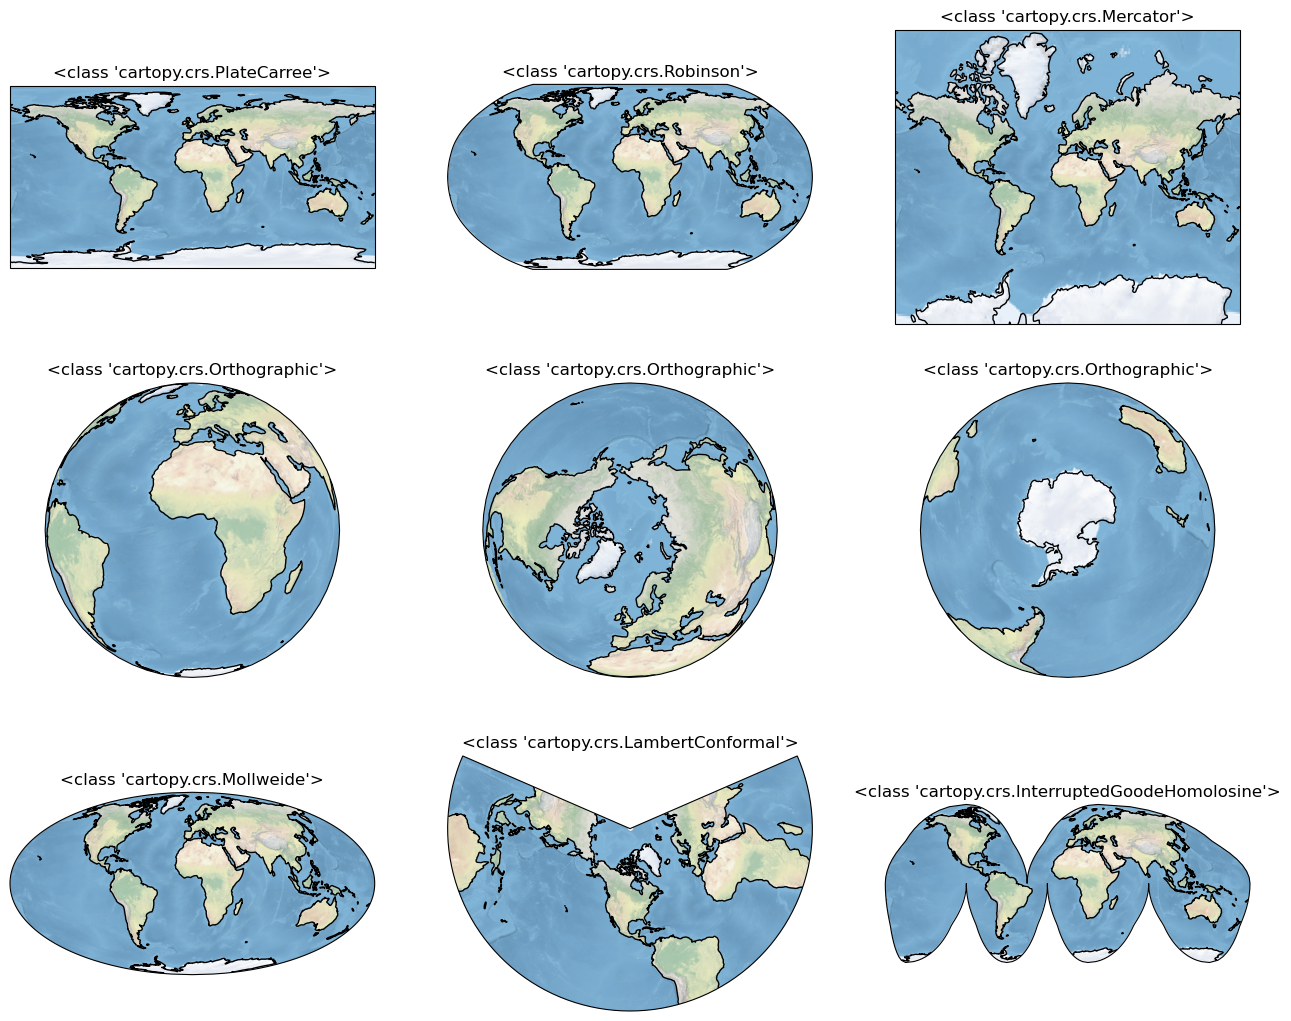

In [2]:
# list of "common" projections
# code adapted from Ryan Abernathey (https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html)

projections = [ccrs.PlateCarree(),
               ccrs.Robinson(),
               ccrs.Mercator(),
               ccrs.Orthographic(),                                            # default center at (0,0)
               ccrs.Orthographic(central_latitude=90),                         # northern orthographic
               ccrs.Orthographic(central_longitude=90, central_latitude=-90),  # southern orthographic with shift
               ccrs.Mollweide(),
               ccrs.LambertConformal(),
               ccrs.InterruptedGoodeHomolosine()
              ]

fig = plt.figure(figsize=(16, 13))

for i, proj in enumerate(projections):
    ax = plt.subplot(3, 3, i+1, projection=proj)
    ax.stock_img()
    ax.coastlines()
    ax.set_title(f"{type(proj)}")

Lets try it on some data. Below code loads the WOA13 surface (conservative) temperature data in xarray, and then does a basic plot using the Plate Carree projection. The main addition here are:

* the `projection=CARTOPY_PROJECTION` to the axes object, which makes it into a cartopy axes

* `ax.add_feature(cartopy.feature.LAND)` which adds land features onto the map
  * if you are running this in Colab, it will download the files on the fly, but if you exist Colab you will have to re-download it on the fly next time because none of the download on-the-fly packages/data are cached

> NOTE: Instead of repeatedly called `ccrs.PlateCarree()` I just defined it as `pcarree = ccrs.PlateCarree()`. The reason is that the associated object is used in various places even if when we are not dealing with the Plate Carree projection itself. See examples later.

In [3]:
# load the temperature profiles

option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    file = "temperature_WOA13_decav_Reg1L46_clim.nc"
elif option == "remote":
    # do a local caching (downloads a file to cache)
    print("loading data remotely")
    file_loc = "https://github.com/julianmak/OCES3301_data_analysis/raw/refs/heads/main/temperature_WOA13_decav_Reg1L46_clim.nc"
    file = fsspec.open_local(f"simplecache::{file_loc}", filecache={'cache_storage': '/tmp/fsspec_cache'})
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

toce_WOA13 = xr.open_dataset(file)

lon, lat = toce_WOA13["lon"], toce_WOA13["lat"]
toce = toce_WOA13["votemper"].isel(lev=0)  # only pick out the surface data

loading data remotely


Text(0.5, 1.0, '$\\Theta(z=0, t=6.0)$')

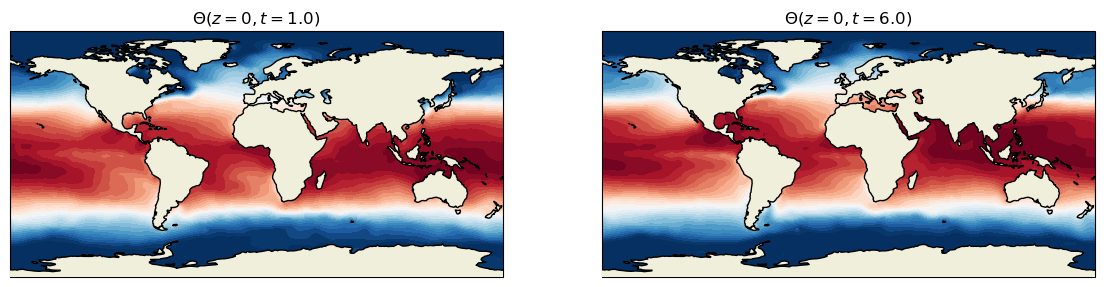

In [4]:
# define the axes with projections
pcarree = ccrs.PlateCarree()

# define some plot options
plot_opts = {"cmap"   : "RdBu_r",
             "levels" : np.linspace(0, 30, 31),
             "extend" : "both"}

fig = plt.figure(figsize=(14, 5))

kt = 0
ax = plt.subplot(1, 2, 1, projection=pcarree)
ax.contourf(lon, lat, toce.isel(time=kt), **plot_opts)
ax.add_feature(cartopy.feature.LAND, zorder = 10, edgecolor = 'k')
ax.set_title(f"$\Theta(z=0, t={toce.time[kt].values})$")

kt = 5
ax = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax.contourf(lon, lat, toce.isel(time=kt), **plot_opts)
ax.add_feature(cartopy.feature.LAND, zorder = 10, edgecolor = 'k')
ax.set_title(f"$\Theta(z=0, t={toce.time[kt].values})$")

The maps above could do with a bit more decoration, because for example it is not very obvious how different the January data (left) is to the June data (right). The decorations below are:

* `gl=ax.gridlines` for gridlines
  * modifications to grid lines through modifying the `gl` object attributes; see below

* adding axes labels as `ax.text` (`ax.set_xlabel` behaves differently for the cartopy axes)

* `divider = make_axes_locatable(ax)` in preparation for a colorbar (this is a native `matplotlib` command)
  * done this way to make sure colorbar scales with the plot size, otherwise it looks a bit off

Text(0.5, 1.0, '$^\\circ\\mathrm{C}$')

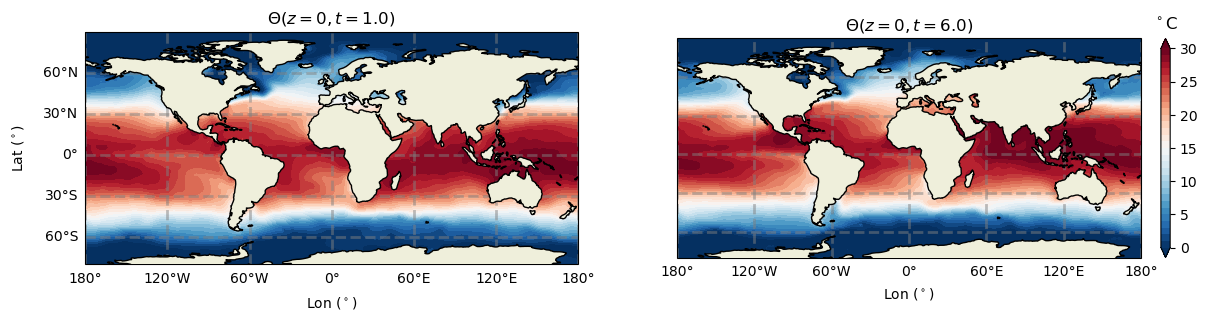

In [5]:
# as above but with a bit more decorations

fig = plt.figure(figsize=(14, 5))

kt = 0
ax = plt.subplot(1, 2, 1, projection=pcarree)
ax.contourf(lon, lat, toce.isel(time=kt), **plot_opts)
ax.add_feature(cartopy.feature.LAND, zorder = 10, edgecolor = 'k')
ax.set_title(f"$\Theta(z=0, t={toce.time[kt].values})$")

gl = ax.gridlines(crs=pcarree, draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent([-180, 180, -80, 90], crs=pcarree)
ax.text(0.5, -0.20, r'Lon $\left( {}^\circ \right)$',
        va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(-0.12, 0.5, r'Lat $\left( {}^\circ \right)$',
        va='bottom', ha='center',
        rotation=90, rotation_mode='anchor',
        transform=ax.transAxes)

kt = 5
ax = plt.subplot(1, 2, 2, projection=pcarree)
cs = ax.contourf(lon, lat, toce.isel(time=kt), **plot_opts)  # define cs for making the colorbar
ax.add_feature(cartopy.feature.LAND, zorder = 10, edgecolor = 'k')
ax.set_title(f"$\Theta(z=0, t={toce.time[kt].values})$")

gl = ax.gridlines(crs=pcarree, draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
ax.set_extent([-180, 180, -80, 90], crs=pcarree)
ax.text(0.5, -0.20, r'Lon $\left( {}^\circ \right)$',
        va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)

divider = make_axes_locatable(ax)  # add a colorbar
cb_ax = divider.append_axes("right", size = "2%", pad = 0.2, axes_class=plt.Axes)
cax = plt.colorbar(cs, cax=cb_ax)
cax.set_ticks([0, 5, 10, 15, 20, 25, 30])
cax.ax.set_title(r"$^\circ\mathrm{C}$")

Below shows zooms and so forth, still sticking with the plate Carree projection. Some comments:

* one could set the zoom by `ax.set_extent` if you are only dealing with `contourf`

* when combined with contours I don't find the results very satisfactory, so what I did was to select the data I want through indexing (done via xarray), and then plot the data, instead of relying on `ax.set_extent`

* I did the `contourf` results first and then overlaid the `lines=contour` results to show some labelled contour lines (`ax.clabel(lines, inline=True)`), using the same subsetting procedure as above
  * if you rely on `ax.set_extent` then the labels may not show in your zoomed in region, and the inline labelling might look a bit weird

Text(0.5, -0.2, 'Lon $\\left( {}^\\circ \\right)$')

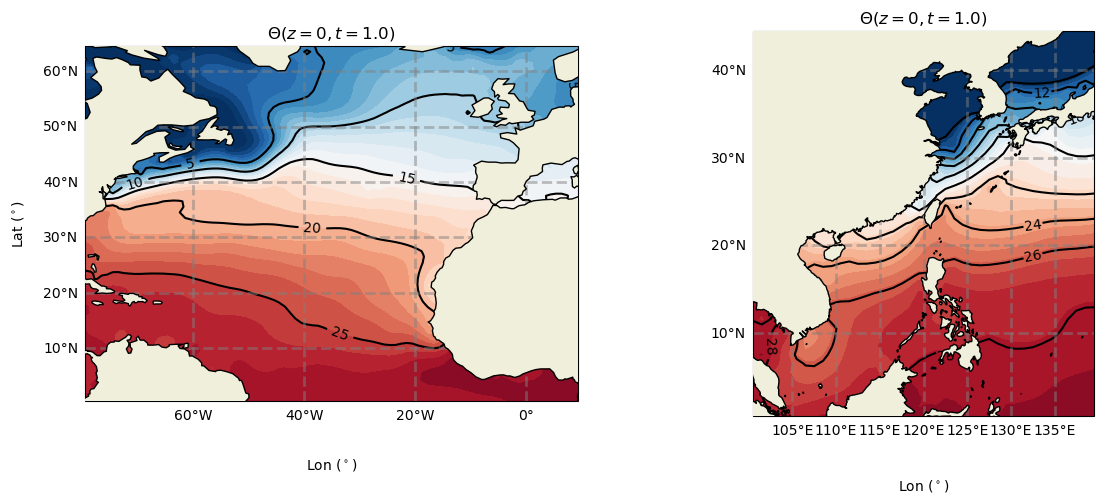

In [6]:
# zoom in to various places

fig = plt.figure(figsize=(14, 5))

kt = 0

plot_opts = {"cmap"   : "RdBu_r",
             "levels" : np.linspace(0, 30, 31),
             "extend" : "both"}

# define limits to do things over: North Atlantic here
lon_lim, lat_lim = (-80, 10), (0, 65)

ax = plt.subplot(1, 2, 1, projection=pcarree)

# note: the contour labels and gridlines are nicer if you force a plot based on the sliced out data
#       (another way to do it is to set the extent, see the commented line below)
ax.contourf(lon.sel(lon=slice(lon_lim[0], lon_lim[1])),
            lat.sel(lat=slice(lat_lim[0], lat_lim[1])),
            toce.isel(time=kt).sel(lon=slice(lon_lim[0], lon_lim[1]), lat=slice(lat_lim[0], lat_lim[1])),
            **plot_opts)
lines = ax.contour(lon.sel(lon=slice(lon_lim[0], lon_lim[1])),
                   lat.sel(lat=slice(lat_lim[0], lat_lim[1])),
                   toce.isel(time=kt).sel(lon=slice(lon_lim[0], lon_lim[1]), lat=slice(lat_lim[0], lat_lim[1])),
                   colors="k", levels=np.arange(5, 31, 5))
ax.clabel(lines, inline=True)
ax.add_feature(cartopy.feature.LAND, zorder = 10, edgecolor = 'k')
ax.set_title(f"$\Theta(z=0, t={toce.time[kt].values})$")

gl = ax.gridlines(crs=pcarree, draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
# ax.set_extent([lon_lim[0], lon_lim[1], lat_lim[0], lat_lim[1]], crs=pcarree)
ax.text(0.5, -0.20, r'Lon $\left( {}^\circ \right)$',
        va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(-0.12, 0.5, r'Lat $\left( {}^\circ \right)$',
        va='bottom', ha='center',
        rotation=90, rotation_mode='anchor',
        transform=ax.transAxes)

# define limits to do things over: South China Sea + Pacific
lon_lim, lat_lim = (100, 140), (0, 45)

plot_opts = {"cmap"   : "RdBu_r",
             "levels" : np.linspace(10, 30, 30),
             "extend" : "both"}

ax = plt.subplot(1, 2, 2, projection=pcarree)
cs = ax.contourf(lon.sel(lon=slice(lon_lim[0], lon_lim[1])),
                 lat.sel(lat=slice(lat_lim[0], lat_lim[1])),
                 toce.isel(time=kt).sel(lon=slice(lon_lim[0], lon_lim[1]), lat=slice(lat_lim[0], lat_lim[1])),
                 **plot_opts)  # define cs for making the colorbar
lines = ax.contour(lon.sel(lon=slice(lon_lim[0], lon_lim[1])),
                   lat.sel(lat=slice(lat_lim[0], lat_lim[1])),
                   toce.isel(time=kt).sel(lon=slice(lon_lim[0], lon_lim[1]), lat=slice(lat_lim[0], lat_lim[1])),
                   colors="k", levels=np.arange(10, 30, 2))
ax.clabel(lines, inline=True)
ax.add_feature(cartopy.feature.LAND, zorder = 10, edgecolor = 'k')
ax.set_title(f"$\Theta(z=0, t={toce.time[kt].values})$")

gl = ax.gridlines(crs=pcarree, draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
# ax.set_extent([lon_lim[0], lon_lim[1], lat_lim[0], lat_lim[1]], crs=pcarree)
ax.text(0.5, -0.20, r'Lon $\left( {}^\circ \right)$',
        va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)

In the below I do something similar but for the GEBCO bathymetry data and showing these in different map projections (the Mercator and North Pole centered orthographic). Comments:

* the different projections are achieved by changing the `projection` keyword in the axes object

* note the addition in this case of `transform=pcarree` in the `contourf` commands
  * no I don't know why the transform is pcarree when the projection is Mercator, if you find out tell me...
  
* I downsized the data because any transform away from standard pcarree can take some time (I think this is especially true when the orthographic projections are concerned)
  * downsizing by a factor of 4 (`[::4]`) seems to be alright, but you will notice it still takes a bit of time to show the results
  * downsizing by anything larger than 6 I found the results started to look a bit too smudged and losing visually noticeable details, but feel free to experiment with this

In [7]:
# load bathymetry data

option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    file = "gebco_bathy_coarsen.nc"
elif option == "remote":
    # do a local caching (downloads a file to cache)
    print("loading data remotely")
    file_loc = "https://github.com/julianmak/OCES3301_data_analysis/raw/refs/heads/main/gebco_bathy_coarsen.nc"
    file = fsspec.open_local(f"simplecache::{file_loc}", filecache={'cache_storage': '/tmp/fsspec_cache'})
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

bathy = xr.open_dataset(file)

loading data remotely


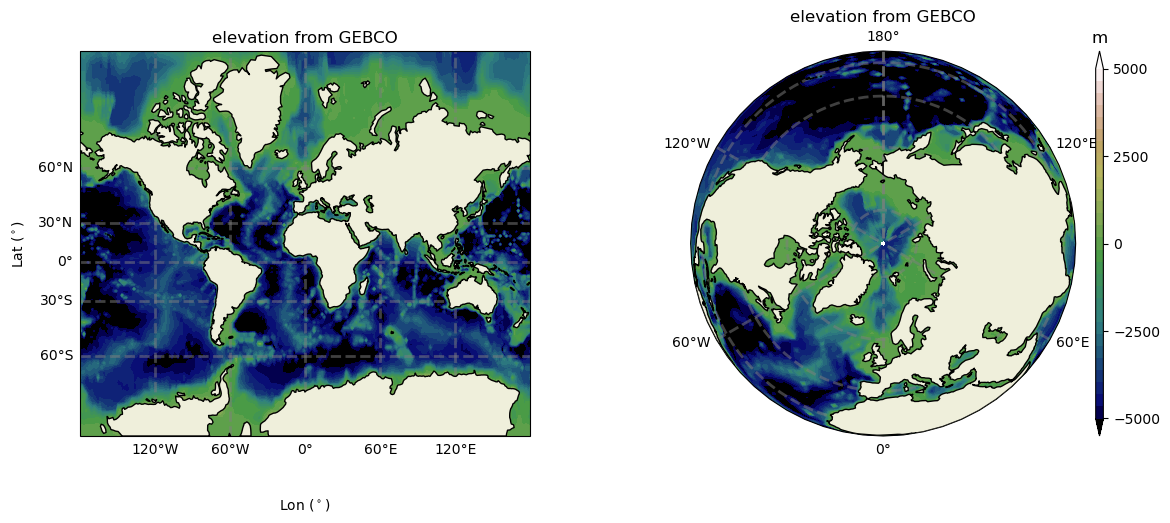

In [8]:
# plotting bathymetry but in a different projection

fig = plt.figure(figsize=(14, 5))

plot_opts = {"cmap"   : "gist_earth",
             "levels" : np.linspace(-5000, 5000, 30),
             "extend" : "both"}

# mercator projection
ax = plt.subplot(1, 2, 1, projection=ccrs.Mercator())
ax.contourf(bathy["lon"][::4],
            bathy["lat"][::4],
            bathy["elev"][::4, ::4],
            transform=pcarree, **plot_opts)  #
ax.add_feature(cartopy.feature.LAND, zorder = 10, edgecolor = 'k')
ax.set_title(f"elevation from GEBCO")

gl = ax.gridlines(crs=pcarree, draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent([-180, 180, -80, 90])
ax.text(0.5, -0.20, r'Lon $\left( {}^\circ \right)$',
        va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(-0.12, 0.5, r'Lat $\left( {}^\circ \right)$',
        va='bottom', ha='center',
        rotation=90, rotation_mode='anchor',
        transform=ax.transAxes)

# northern orthographic (sometimes northern stereographic)
ax = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(central_longitude=0, central_latitude=90))
cs = ax.contourf(bathy["lon"][::4],
                 bathy["lat"][::4],
                 bathy["elev"][::4, ::4],
                 transform=pcarree, **plot_opts)  # define cs for making the colorbar
ax.add_feature(cartopy.feature.LAND, zorder = 10, edgecolor = 'k')
ax.set_title(f"elevation from GEBCO")
ax.set_global()  # NOTE: seem to need this magic line to display the plot in this projection

gl = ax.gridlines(crs=pcarree, draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

divider = make_axes_locatable(ax)  # add a colorbar
cb_ax = divider.append_axes("right", size = "2%", pad = 0.2, axes_class=plt.Axes)
cax = plt.colorbar(cs, cax=cb_ax)
cax.ax.set_title(r"$\mathrm{m}$")
cax.set_ticks([-5000, -2500, 0, 2500, 5000])

> <span style="color:red">**Q.**</span> Have some fun with these, maybe make some movies with the data or whatever. Ask me if you want some data like `current_speed.nc` below but over a different region to generate movies with (e.g. data just off the Drake passage in the Southern Ocean for example).

--------------------------
# b) Spatial interpolation

Recall that in *08_time_series* we had missing data and we ended up interpolating in time. We can basically do the same thing in space. The ideas and things to be aware of are basically the same, except there are subtleties with extra dimensions you have to be careful about (e.g. a cubic spline is a polynomial fitting of data points, but what does a 2d polynomial even mean?)

Will just go straight into an example of this that also combines the use of Cartopy above. Below demonstration is an outline on how I generated parts of the figure in a recent paper ([Thomy et al 2024](https://doi.org/10.1093/ismeco/ycae109), Fig 1a), which is to plot a reconstruction/modelled Sea Surface Salinity over the HK area. The complications and the wish to do interpolation will arise as I show the data.

First we load the salinity data. The data is originally from [HYCOM](https://www.hycom.org/), and I took the surface salinity over the month of June in some year and then averaged it in time, so the data is only a function of latitude and longitude, at about 9km horizontal resolution.

In [9]:
# load bathymetry data

option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    file = "June_2020_meanSalinity.nc"
elif option == "remote":
    # do a local caching (downloads a file to cache)
    print("loading data remotely")
    file_loc = "https://github.com/julianmak/OCES3301_data_analysis/raw/refs/heads/main/June_2020_meanSalinity.nc"
    file = fsspec.open_local(f"simplecache::{file_loc}", filecache={'cache_storage': '/tmp/fsspec_cache'})
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

hycom_data = xr.open_dataset(file)
hycom_data = hycom_data.isel(depth=0) # get rid of that floating singleton dimension
hycom_data

loading data remotely


<xarray.Dataset> Size: 5kB
Dimensions:   (lat: 38, lon: 32)
Coordinates:
    depth     float64 8B 0.0
  * lat       (lat) float64 304B 21.52 21.56 21.6 21.64 ... 22.92 22.96 23.0
  * lon       (lon) float64 256B 112.5 112.6 112.6 112.7 ... 114.8 114.9 115.0
Data variables:
    salinity  (lat, lon) float32 5kB ...

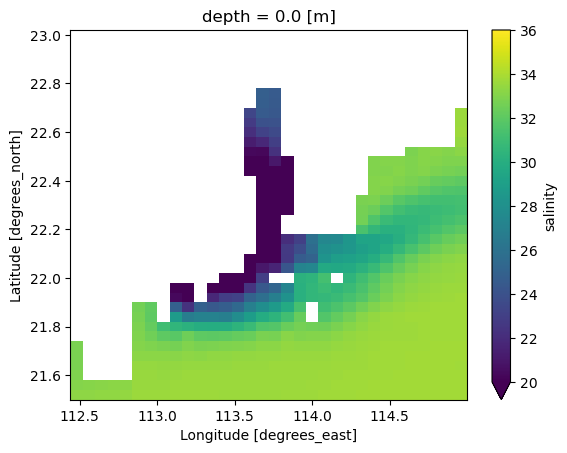

In [10]:
# raw plot
hycom_data["salinity"].plot(vmin = 20, vmax = 36)

If you squint your eyes a bit, the modelled Pearl River Delta region is the bit with lower salinity (because of freshwater input). The salinity signal indicates the flow out of the river goes towards the southwest, which is consistent with the Summer phase of the monsoon over the region (cf. `lec02`, `lec05`, `lec09` and `lec10` of `OCES2003` lecture). HK and the surrounding islands are those little white dots to the east of the Pearl River.

The above is using `pcolor` that plots per grid cell. We could try and see if plotting with `contourf` would be a bit better. Going to enable some of the `cartopy` features also.

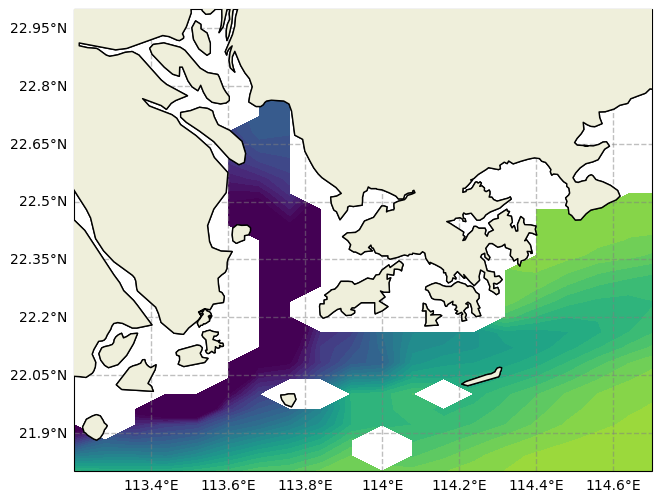

In [11]:
# plotting raw hycom data using contourf
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([113.2, 114.7, 21.8, 23.0],ccrs.PlateCarree())
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cartopy.feature.LAND, zorder=3, edgecolor = 'k')

ax.contourf(hycom_data["lon"], hycom_data["lat"], hycom_data["salinity"],
            levels=np.linspace(20, 36, 31), extend="both", cmap = "viridis")

Looks a bit ugly doesn't it? The white blocks are where there is no data (`NaN`s), so at least `contourf` did the nice thing by ignoring those, otherwise the code would fail. What we can do is to fill out some of the white blocks via interpolation, and then try again.

Recall the previous for interpolation we had to provide co-ordinates and the values, i.e.
* an 1d array `t` where there is data
* an 1d array `data` (or `f` in the previous notebooks) where the data is
and we had to blank out the `NaN` values, otherwise the interpolator breaks. Doing it in 2d is similar, and we need to provide (in this case)
* a 1d x 2 array `coords` where the data lives, where the array consists of a collection of locations
* a 1d array `data` (or `f` in the previous notebooks) where the data lives
This part is slightly different because by default the data is in the form

\begin{equation*}
    \begin{pmatrix}
        f(y_1, x_1) & f(y_2, x_1) & \ldots & f(y_n, x_1)\\
        f(y_1, x_2) & \ddots      & \cdots & \vdots\\
        \vdots      & \ddots      & \ddots & \vdots\\
        f(y_1, x_m) & \cdots      & \cdots & f(y_n, x_m)
    \end{pmatrix}, \qquad
    \begin{pmatrix}
        y_1 & y_2 & \ldots & y_n\\
        y_1 & \ddots      & \cdots & \vdots\\
        \vdots      & \ddots      & \ddots & \vdots\\
        y_1 & \cdots      & \cdots $ y_n
    \end{pmatrix}, \qquad
    \begin{pmatrix}
        x_1 & x_1 & \ldots & x_1\\
        x_2 & \ddots      & \cdots & \vdots\\
        \vdots      & \ddots      & \ddots & \vdots\\
        x_m & \cdots      & \cdots $ x_m
    \end{pmatrix},
\end{equation*}

or similar for the data and co-ordinate arrays. What we really want to do is for them to be written as

\begin{equation*}
    \begin{pmatrix}
        f(y_1, x_1) \\
        f(y_2, x_1) \\
        \vdots \\
        f(y_n, x_1)\\
        f(y_1, x_2)\\
        \vdots\\
        f(y_n, x_m)
    \end{pmatrix}, \qquad
    \begin{pmatrix}
        y_1 & x_1 \\
        y_2 & x_1 \\
        \vdots & \vdots \\
        y_n & x_1\\
        y_1 & x_2\\
        \vdots & \vdots\\
        y_n & x_m
    \end{pmatrix},
\end{equation*}
i.e. as a "flattened" or "reshaped" into a collection of data and co-ordinates. The below code does this as a whole block:

0) pull out the relevant data as an `numpy` array (don't really have to do this, but doing it for safety)
1) find out the indices of all the `NaN` points first (which are land points)
2) the co-ordinate files are 1d, but going to bulk it out to 2d corresponding to the data points
3) pick out only the data that are not `NaN` (i.e. the wet points)
4) reshape co-ordinate and data arrays from 2d meshes onto 1d-like arrays (done here using the `.flatten()` command tagged with numpy arrays; the bulking out above makes sure it is flattened consistently)
5) throw this into a choice of 2d interpolator (just chose one here)
6) evaluate accordingly even over the land points

In [12]:
# interpolating hycom data

# 0) pull out data
sal_hycom = hycom_data["salinity"].values
lon_hycom = hycom_data["lon"].values
lat_hycom = hycom_data["lat"].values

# 1) pick out land points (done as a boolean)
nan_inds = np.isnan(sal_hycom)

# 2) bulk out the co-ordinates
xx, yy = np.meshgrid(lon_hycom, lat_hycom)
orig_shape = xx.shape # for reverting to original shape later

# 3) pick out all the *non*-NaN points
wet_vals = np.zeros((np.sum(~nan_inds), 2))  # "sum" finds how many wet points there are
wet_vals[:, 0] = xx[~nan_inds] # this already flattens the array
wet_vals[:, 1] = yy[~nan_inds]

# 4, 5) flatten array and throw into interpolator (Clougher2D is like a cubic spline fitting)
# the [~nan_inds] already flattens array
f = interpolate.CloughTocher2DInterpolator(wet_vals, sal_hycom[~nan_inds])

# 6) re-evaluate at all points
lonlat = np.zeros((xx.size, 2))
lonlat[:, 0] = xx.flatten()  # this one does need flattening
lonlat[:, 1] = yy.flatten()
sal_interp = f(lonlat).reshape(orig_shape)  # evalute on flattened array, then revert it

Text(0.5, 1.0, 'interpolated data')

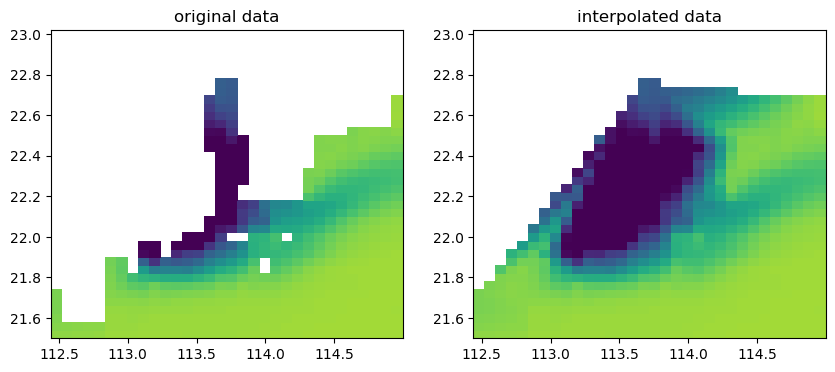

In [13]:
# plot out the data with pcolor to make a point

fig = plt.figure(figsize=(10, 4))

ax = plt.subplot(1, 2, 1)
ax.pcolor(lon_hycom, lat_hycom, sal_hycom, vmin=20, vmax=36, cmap = "viridis")
ax.set_title("original data")

ax = plt.subplot(1, 2, 2)
ax.pcolor(lon_hycom, lat_hycom, sal_interp, vmin=20, vmax=36, cmap = "viridis")
ax.set_title("interpolated data")

Notice the interpolator provides some numbers at some points but not others (returning `NaN` at those places).

> <span style="color:red">**Q.**</span> Can you see/guess the condition on where the interpolator provides results? (hint: the definition of ***convex hull*** might help)

Some interpolated values are probably a bit dubious (e.g. the ones on the west side of the Pearl River Delta), and the values that are now over land never existed in the first place so should not be used really. For the purposes of the interpolation was done to provide a reasonable plot: the dubious values get covered up by the land anyway, and we never do calculations with it, so it's at least justified from that point of view. Covering it with the land and tidying it results in the following:

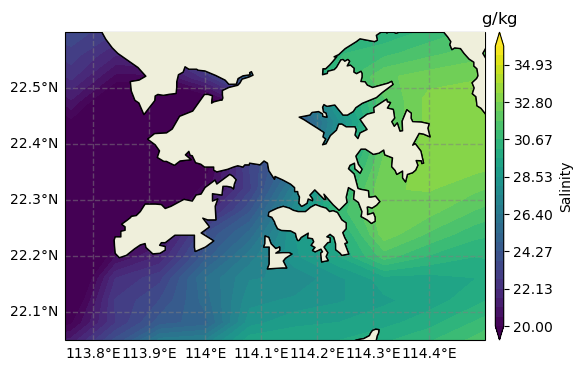

In [14]:
# plotting interpolated hycom data step
fig = plt.figure(figsize=(6,4))
ax = plt.axes(projection = pcarree)
ax.set_extent([113.75, 114.5, 22.05, 22.6])  # zoom in over HK
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.add_feature(cartopy.feature.LAND, zorder=3, edgecolor = 'k')

cs = ax.contourf(lon_hycom, lat_hycom, sal_interp, levels=np.linspace(20, 36, 31),
                 extend="both", cmap = "viridis")

# create the axes by grabbing the bounding boxes of the individual plot axes
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="2%", pad=0.1, axes_class=plt.Axes)

# create the axes by grabbing the bounding boxes of the individual plot axes
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="2%", pad=0.1, axes_class=plt.Axes)

fig.add_axes(ax_cb)
plt.colorbar(cs, cax=ax_cb)
ax_cb.set_ylabel(r"Salinity")
ax_cb.set_title(r"$\mathrm{g}/\mathrm{kg}$")

cs.set_edgecolors("face") # old magic command to get rid of white lines in contourf outputs

> <span style="color:red">**Q.**</span> Look up the manual to see what other interpolators are available, and try to swap out interpolators to see if differences and similarities (particularly try `scipy.interpolate.interp2d(kind="linear")` or `nearest`).

> <span style="color:red">**Q.**</span> Try computing statistics and the like and see how badly it gets screwed up by the presence of the interpolators.

> <span style="color:red">**Q.**</span> Some locations are definitely bad for computing statistics on (the clearly land points), but some might be defensible (e.g. some of the land points according to HYCOM, but are really blocked out because of islands). Have a think and try and identify how to pick out the partially wet poitns, and compute statistics over those instead.

--------------------------
# c) Empirical Orthogonal Functions (EOFs)

#### ***TL;DR: basically PCAs***

When we were dealing with Fourier series we essentially assumed we have a basis function in advance (see `08_time_series` and above) and expand our function with it, and as a result we deal with the amplitude. This is all well and good if you know your basis in advance, but sometimes that doesn't work (e.g. complicated domain shapes), and sometimes you don't necessarily want to do that. We may for example seek something like

\begin{equation*}
    f(t,x,y) = \sum_{k=1}^N \mbox{PC}_k(t)\ \mbox{EOF}_k(x,y)
\end{equation*}

where the function $\mbox{EOF}(x,y)$ is some spatial pattern that captures the most variability in the data in some sense, and tagged on with it some $\mbox{PC}(t)$ that describes that pattern's evolution in time. The idea then is that the first few EOFs would be related to the large-scale persistent (in space and time) features, and other things would be additional details on top of that. We might then be more inclined to try and come up with theories that explain the dominant EOFs, or constrain theories based on whether they are able to reproduce these EOFs.

Sounds familiar? Well that's basically what the PCA (`04_regression`) aims to do as well. The EOF analysis could be thought of as a generalised PCA, and while there are some detailed differences, the principles and the algorithms involved are more similar than they are different.

The main technical difference is that, for the PCA, we essentially want to form the **covariance matrix** (see `04_regression`), which is necessarily symmetric by construction, diagnonalise the matrix, from which the eigenvectors are the PCs, and the eigenvalues are the variance explained. For the EOF, what in generally do is to start with $f(t,x,y)$, reshape it into $f(t, \mathrm{space})$, and generically the dimensions of $t$ and $\mathrm{space}$ will not agree, and if we form the covariance matrix we would have to artificially bulk out locations with empty numbers to make sure the eventual covariance matrix is square. To avoid this, we generally consider what would be called a **singular value decomposition (SVD)**, which considers the decomposition

\begin{equation*}
    \mathbf{\mathsf{F}} = \mathbf{\mathsf{U}} \mathbf{\mathsf{\Sigma}} \mathbf{\mathsf{V}}^T,
\end{equation*}

where:

* $\mathbf{\mathsf{F}}$ is the matrix encoding $f(t, \mathrm{space})$
* $\mathbf{\mathsf{\Sigma}}$ is the matrix containing the **singular values** $d\sim \sigma^2$, where $\sigma^2$ is the variance
* $\mathbf{\mathsf{U}}$ is the matrix of the **principal components**, where the *rows* correspond to $\mbox{PC}_k(t)$ (e.g. `U[:, 0]` would be $\mbox{PC}_1(t)$)
* $\mathbf{\mathsf{V}}^T$ is the matrix containing the **empirical orthogonal functions**, where *columns* of $\mathbf{\mathsf{V}}^T$ correspond to $\mbox{EOF}_k(\mathrm{space})$ (e.g. `VT[0, :]` would be $\mbox{EOF}_0(\mathrm{space})$, which needs to be reshaped back to $\mbox{EOF}_0(x, y)$)

The ordering is such that we are in descending order of the magnitude of the singular values. Put another way, the PCs and EOFs are really the **left/right singular vectors** ($\mathbf{\mathsf{U}}$ and $\mathbf{\mathsf{V}}$ are the matrices containing the singular vectors). The maximum number of singular values (i.e. maximum size of $\mathbf{\mathsf{\Sigma}}$) and thus the maximum number of singular vectors is the minimum of the size between $t$ and $\mathrm{space}$.

> NOTE: Most PCA algorithms actually use the SVD approach, instead of the eigenvalue approach I described. SVDs can be applied to non-square matrices, and the algorithms are generally stable and fairly fast.

Unless you are really keen we don't actually need to implement the EOF analysis by hand from scratch (unless you want to, it's not actually that hard; see optional exercise at the end). We can leverage `PCA` in the `scikit-learn` package as is, and the only thing we need to do is do some pre-processing of data before feeding data into the PCA, and undo the processing afterwards for the EOFs (the PCs drops out as is).

## Example: "trivial" sines and cosines

Let's try it with a simple example first. The below code is copy and pasted from `09_fun_with_maps` for the purposes of demonstrating how to make animations. The function we define here is

\begin{equation*}
    f(t, y, x) = \sin(x)\cos(y)\sin(t) + 0.5 \cos(2x) \cos(2t).
\end{equation*}

The first part on the right hand side is from `09_fun_with_maps`, and I added on the the second part for demonstration reasons. Given your now extensive experience with Fourier analysis (!), you would know that a Fourier analysis of $f(t,y,x)$ would unequivocally pick out the two contributions separately. The question here is what would the EOF analysis do?

Intuitively, we would expect the EOF analysis to also pick our those components. Given the choice of amplitudes I fed into defining $f$, we might expect that

\begin{equation*}
    \mbox{EOF}_1(x,y) \sim \sin(x)\cos(y), \qquad \mbox{PC}_1(t) \sim \sin(t),
\end{equation*}

\begin{equation*}
    \mbox{EOF}_2(x,y) \sim \cos(2x), \qquad \mbox{PC}_2(t) \sim \cos(2t),
\end{equation*}

\begin{equation*}
    \mbox{EOF}_k(x,y) \sim 0, \qquad \mbox{PC}_k(t) \sim 0, \qquad k \geq 3
\end{equation*}

where I used the squiggle $\sim$ to denote that these things would be defined up to a constant factor (negative or positive). Additionally, we should be able to reconstruct exactly (or at least numerically) the function $f$ from the EOFs and PCs.

Let's define the raw data first.

In [15]:
# snapshots with a different colour map to show oscillations

x_vec = np.linspace(0, 2*np.pi, 21)
y_vec = np.linspace(0, 2*np.pi, 26)
t_vec = np.linspace(0, 2*np.pi, 21)

xx, yy = np.meshgrid(x_vec, y_vec)  # creates a mesh (a 2d array) from the 1d arrays
f = np.zeros((len(t_vec), len(y_vec), len(x_vec)))  # use (t, y, x) ordering
for kt in range(len(t_vec)):
    t = t_vec[kt]
    f[kt, :, :] =  (        np.sin(  xx) * np.cos(yy) * np.sin(t)
                    + 0.5 * np.cos(2*xx)              * np.cos(2*t)
                   )
del xx, yy

Recall that from the PCA we want to scale the data and get some anomalies (done by a $Z$-transform, through the `StandardScaler` in `sklearn`). For the EOF we want to scale the input data too, but it looks like in this case we want to de-trend or at least de-mean in time per spatial point, rather than do a $Z$-transform.

The below carries out a de-trending (linear trend) using `scipy.signal` only over the time dimension; the data here is arranged as $(t,y,x)$ so it is `axis=0` that we want.

> NOTE: If we de-mean, then you want to add the mean back on right at the end when (and if) you are trying to reconstruct the original function from the EOFs and PCs. If we de-trend, then it looks like you basically don't need to do anything more. I can't get it working for the $Z$-transform at all.

In [16]:
# probably want to at least de-mean in time
#   if de-mean, take mean off, get EOFs, but add mean back on to final result)
# f_mean = np.mean(f, axis=0)

# detrend (to get anomalies with respect to linear trend in time) seems to work fine
#    with some minor points in the PCs
f = signal.detrend(f, axis=0)  # could also use keyword "overwrite_data=True"

The next bit is to reshape the matrix from $f(t, y, x)$ into $f(t, \mathrm{space})$, so from a 3d to a 2d array. This is done via the `np.reshape` command. We will be passing the 2d array to the PCA in `scikit-learn`, and at some point we will want to invert the (2d) EOFs back into 3d.

> NOTE: If you look these things up online you might see that some of the Python implementations have the optional keyword `order="F"`, which means Fortran ordering (which differs from the default which is `order="C"`, which is C ordering). I have not found that it made any difference as long as you are consistent when reshaping and un-reshaping.

In [17]:
# reshape from (t, y, x) into (t, space),
# NOTE: order='F' being Fortran ordering might be seen sometimes
#       don't think this matters as long as you are consistent in the reshaping

X = np.reshape(f, (len(t_vec), len(y_vec) * len(x_vec)))

Now we pass the 2d array to PCA routine, which we already encountered in `04_regression`, so I am just going to state it. The PCs in this case is the transformation of the input data, while the EOFs are the components. Below I print out the explained variance ratio (it is a variance presumably converted from the calculated singular values), as well reshape the $\mbox{EOF}_k(\mathrm{space})$, which is a 2d array (labelled here by $k$ and $\mathrm{space}$), back into $\mbox{EOF}_k(y, x)$, which is a 3d array (labelled here by $k$, $y$ and $x$).

In [18]:
# basically do a PCA
pca = PCA(n_components=5)

# pull out the PCs and EOFs
PCs             = pca.fit_transform(X)
EOFs_to_reshape = pca.components_

print(f"pca var explained = {pca.explained_variance_ratio_ * 100} %")

# reshape the EOFs from (EOF number, space) to  (EOF number, y, x)
EOFs = np.reshape(EOFs_to_reshape, (EOFs_to_reshape.shape[0], len(y_vec), len(x_vec)))

pca var explained = [5.46019001e+01 4.53980999e+01 1.15370648e-30 2.53919076e-31
 1.46576294e-31] %


From the variance explained, we can see that basically all the variance is captured by the first two EOFs, which is exactly what we expected. We will plot out the first two EOFs (which is a function of space) and their associated PCs (which is a function of time) below.

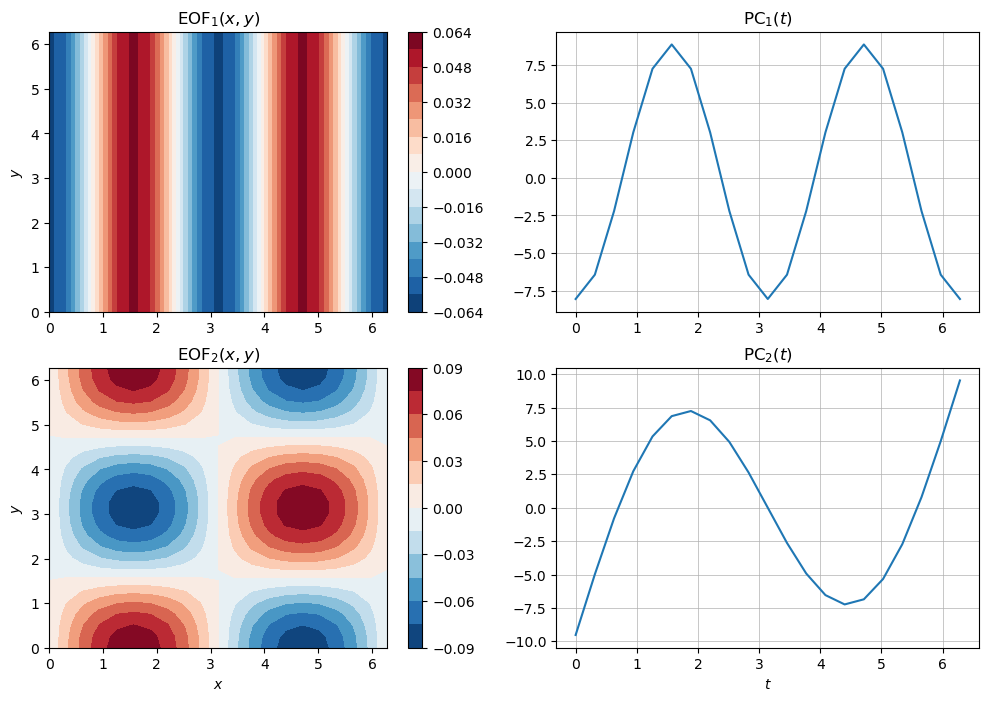

In [19]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(2, 2, 1)
cs = ax.contourf(x_vec, y_vec, EOFs[0, :, :], cmap="RdBu_r", levels=16)
ax.set_title(r"$\mathrm{EOF}_1(x,y)$")
ax.set_ylabel(r"$y$")
plt.colorbar(cs)

ax = plt.subplot(2, 2, 2)
ax.plot(t_vec, PCs[:, 0])
ax.set_title(r"$\mathrm{PC}_1(t)$")
ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(2, 2, 3)
cs = ax.contourf(x_vec, y_vec, EOFs[1, :, :], cmap="RdBu_r", levels=16)
ax.set_title(r"$\mathrm{EOF}_2(x,y)$")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
plt.colorbar(cs)

ax = plt.subplot(2, 2, 4)
plt.plot(t_vec, PCs[:, 1])
ax.set_xlabel(r"$t$")
ax.set_title(r"$\mathrm{PC}_2(t)$")
ax.grid(lw=0.5, zorder=0)

So, interestingly, while the PCs corresponding to the EOFs are what we expected (e.g. the $\cos(2x)$ patterns with the $\cos(2t)$ time series), the EOF ordering is the other way round. It turns out this is somewhat of an artifact of the choice of pre-processing: if you do a de-mean procedure instead then the EOFs are the "right" way round. Notice here PC2 looks a bit weird, in that it's not exactly a $\sin(t)$, which is what we imposed when defining $f(t, y, x)$.

In that regard, this is a warning that the EOF analysis requires some sort of anomalies, and can be sensitive to the choice of pre-processing.

The below test utilises the EOFs and PCs to reconstruct the data via

\begin{equation*}
    f(t,x,y) = \sum_{k=1}^2 \mbox{PC}_k(t)\ \mbox{EOF}_k(x,y)
\end{equation*}

The plot is per time $\hat{t}$, and shows the individual $\mbox{PC}_k(\hat{t})\ \mbox{EOF}_k(x,y)$, the full data $f(\hat{t}, y, x)$, and the signed mismatch between $f(\hat{t}, y, x)$ and $\sum_{k=1}^2 \mbox{PC}_k(\hat{t})\ \mbox{EOF}_k(x,y)$. The signed mismatch can be shown to be shown to be tiny and essentially at the machine level for all the time levels.

> <span style="color:red">**Q.**</span> Don't take my word for it, try it and convince yourself I didn't just outright lie in the above two claims (the dependence on pre-processing and the smallness of the signed mismatch).

> <span style="color:red">**Q.**</span> Ideally by code rather than examining the plots visually, demonstrate that numerically the mismatches are small (hint: consider examining the absolute value of the mismatch at every single time step).

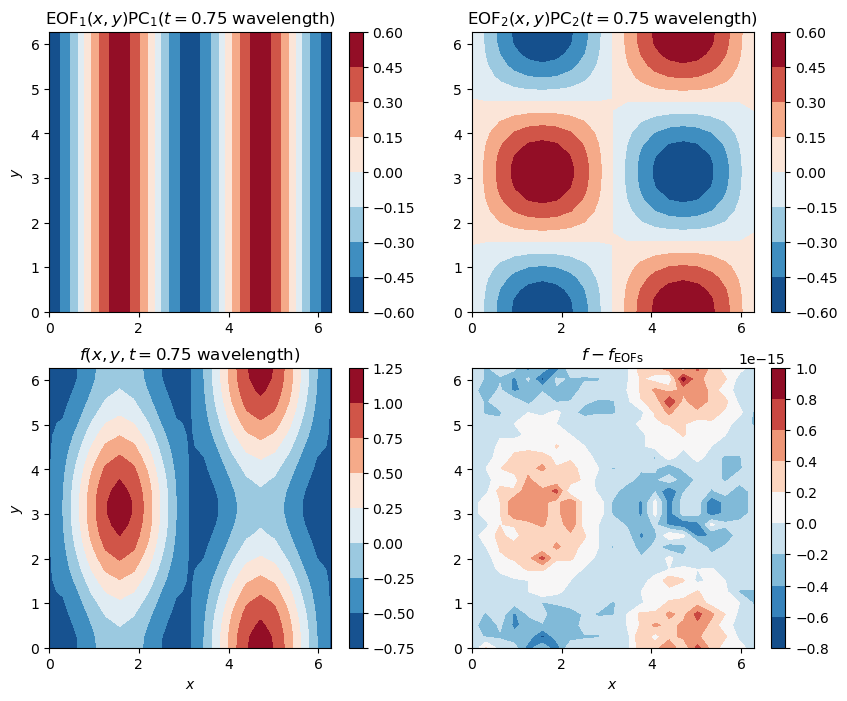

In [20]:
# reconstruct the data at some time

t_ind = 15  # field constructued here to not be identically zero at any choice of t

fig = plt.figure(figsize=(10, 8))

ax = plt.subplot(2, 2, 1)
cs = ax.contourf(x_vec, y_vec, EOFs[0, :, :] * PCs[t_ind, 0], cmap="RdBu_r")
ax.set_ylabel(r"$y$")
ax.set_title(f"$\mathrm{{EOF}}_1(x,y) \mathrm{{PC}}_1(t={t_vec[t_ind]/(2.0*np.pi):.2f}$ wavelength$)$")
plt.colorbar(cs)

ax = plt.subplot(2, 2, 2)
cs = ax.contourf(x_vec, y_vec, EOFs[1, :, :] * PCs[t_ind, 1], cmap="RdBu_r")
ax.set_title(f"$\mathrm{{EOF}}_2(x,y) \mathrm{{PC}}_2(t={t_vec[t_ind]/(2.0*np.pi):.2f}$ wavelength$)$")
plt.colorbar(cs)

ax = plt.subplot(2, 2, 3)
cs = ax.contourf(x_vec, y_vec, f[t_ind, :, :], cmap="RdBu_r")
ax.set_title(f"$f(x,y, t={t_vec[t_ind]/(2.0*np.pi):.2f}$ wavelength$)$")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
plt.colorbar(cs)

# reconstruct the data from the EOFs
f_EOFs = np.zeros((len(y_vec), len(x_vec)))
for i in range(2):
    f_EOFs += EOFs[i, :, :] * PCs[t_ind, i]

ax = plt.subplot(2, 2, 4)
cs = ax.contourf(x_vec, y_vec, f[t_ind, :, :] - f_EOFs, cmap="RdBu_r") # detrend case
ax.set_title(r"$f - f_{\rm EOFs}$")
ax.set_xlabel(r"$x$")
plt.colorbar(cs)

## Example: ERA SST reanalysis data

Lets try this for "real" (ocean) data, partly to demonstrate extra things that we might need to be careful with the analysis, in this case when we encounter land points.

Below code uses xarray to load the [extended reconstructed SST anomaly data](https://www.eea.europa.eu/data-and-maps/data/external/noaa-extended-reconstructed-sea-surface), and just prints out the metadata.

> NOTE: We are going to deal with the anomalies `ssta` directly. There is the full `sst` data on the repository too, but I have to say I have not managed to reconstruct the anomalies from the full data. Partly because I am not entirely sure what the anomalies are relative to (it says relative to some climatology, but that didn't seem to work for me)...
>
> If I were to redo this I would get rid of the linear trend in time from the full data to remove the global warming signal. You can try this yourself, here or in `assignment 4`.

In [21]:
# !wget https://github.com/julianmak/OCES3301_data_analysis/raw/main/ersstv5_ssta.nc  # processed anomaly data
# !wget https://github.com/julianmak/OCES3301_data_analysis/raw/main/ersstv5_sst.nc   # full data

# load the already processed anomalies

option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    file = "ersstv5_ssta.nc"
elif option == "remote":
    # do a local caching (downloads a file to cache)
    print("loading data remotely")
    file_loc = "https://github.com/julianmak/OCES3301_data_analysis/raw/refs/heads/main/ersstv5_ssta.nc"
    file = fsspec.open_local(f"simplecache::{file_loc}", filecache={'cache_storage': '/tmp/fsspec_cache'})
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = xr.open_dataset(file)
df

loading data remotely


<xarray.Dataset> Size: 129MB
Dimensions:  (lev: 1, lat: 89, lon: 180, time: 2007)
Coordinates:
  * lev      (lev) float64 8B 0.0
  * lat      (lat) float64 712B -88.0 -86.0 -84.0 -82.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 16kB 1854-01-31 1854-02-28 ... 2021-03-31
Data variables:
    ssta     (time, lev, lat, lon) float32 129MB ...

Note that the data is monthly. I am going to analyse the Atlantic (the Pacific would be for the assignment or as an extended exercise later). This is partly to demonstrate another issue: data arrangement.

Note that the longitude from metadata goes from 0 to 360. While the data technically is to be interpreted as periodic in longitude, because of how it is set up the data is centered over the Pacific, while if we want the Atlantic (in this case between -80 and 10), xarray would complain in the selection, either giving you longitudes from 0 to 10, or from 280 to 360 (which is -80 to 0). A simple fix here is to just shift the co-ordinate, which is done with the `assign_coords` for an xarray dataset (the `% 360` is *modulo 360*, where the input numbers gets a multiple of 360 taken off to put the input numbers between 0 and 359). We are then going to do the selection using the `sel` command, which comes with xarray objects (saves us having to look up the corresponding indices).

From the metadata, we also see that there is a hanging `lev` dimension floating around (it's just of length 1). Going to get rid of that below by doing `isel(lev=0)`. Going to follow the zeroth rule of data analysis and just plot a sample of the data to see what it looks like.

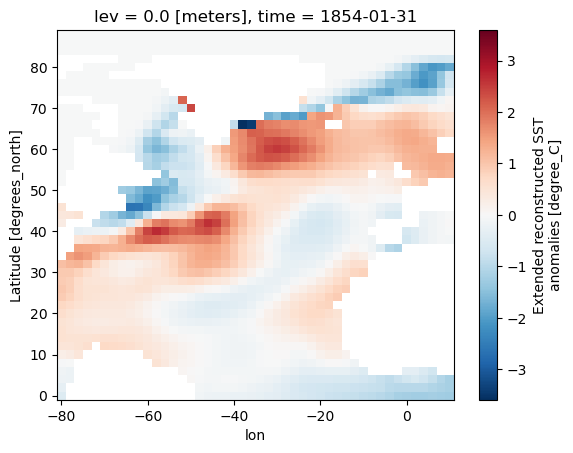

In [22]:
# selection over Atlantic
# current longitude is (0, 360), focus over Pacific
# want Atlantic, quickest thing is to shift the longitude (-180, 180) so centered over the Atlantic
df = df.assign_coords(lon=(((df["lon"] + 180) % 360) - 180)).sortby('lon')

target_lon, target_lat = slice(-80, 10), slice(0, 90)

# trivial selection to drop the z co-ordinate (there is only 1)
ssta = df["ssta"].isel(lev=0).sel(lon=target_lon, lat=target_lat)

# pull out other useful things to carry around
time = df["time"].values
lon  = df["lon"].sel(lon=target_lon).values
lat  = df["lat"].sel(lat=target_lat).values
ssta.isel(time=0).plot()

Here the white entries in the plot are the **land points**, which in the array is indicated by a `NaN` (you can look this up yourself by examining the data matrix itself). What you will find is that PCA can't seem to handle `NaN` entries, so we have to do something about it. There are two ways to do this:

1) use masked arrays in numpy `numpy.ma` probably

2) only do the PCA over the ocean points (I am going to call these **wet points**)

I am going to do the second procedure as it is more robust and general (although somewhat more involved); you can try the first one as a coding excercise.

First I am going to reshape the array into $(t, \mathrm{space})$ as above. Then, since we know the land points correspond to `NaN` entries, we pick out the indices that are *not* `NaNs`, done through:

* `np.where(CONDITION)` which picks out the indices corresponding the conditions
  * `np.where` returns a tuple containing the indices, so there is a `[0]` to pick out the indices
* `np.isnan(ARRAY)` to identify `NaN` entries with `True`
  * `~` is `NOT`, so `~np.isnan(ARRAY)` is to pick out the entries that are *not* `NaN`s
  * we assume the land points don't change in time, so we only need to query the 1st time entry, hence `ARRAY[0, :]`

In [23]:
# already have anomalies, so could just go straight ahead with the EOF analysis
#   not going to weight the gridcells here by the area

X = np.reshape(ssta.values, (len(time), len(lat) * len(lon)))
wet_pts = np.where(~np.isnan(X[0, :]))[0]  # pick out indices corresponding to ocean pts at first time index

We now throw this in to the PCA algorithm, keeping quite a few components in this case. The below output shows a bar graph indicating the percentage of variance explained per EOF (as the blue bars), and the *cumulative* percentage of variance explained by the first $k$ number of EOFs.

pca var explained = [0.21145624 0.10084196 0.08144842 0.06932046 0.04838138 0.04303133
 0.03910842 0.03303799 0.02877615 0.02461037 0.02165814 0.02094981
 0.01882874 0.01697062 0.01592214 0.01378654 0.01278489 0.01197632
 0.01144364 0.01099476]


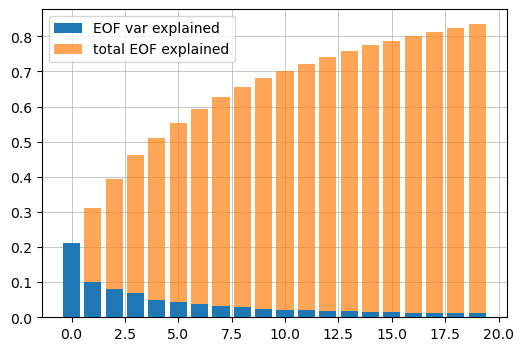

In [24]:
# basically do a PCA:
pca = PCA(n_components=20)

# pull out the PCs and EOFs
PCs             = pca.fit_transform(X[:, wet_pts])  # only do EOF analysis over the wet points
EOFs_to_reshape = pca.components_

print(f"pca var explained = {pca.explained_variance_ratio_}")

fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.bar(np.arange(0, 20), pca.explained_variance_ratio_, color="C0",
       label=r"EOF var explained",
       zorder=3)
ax.bar(np.arange(0, 20), np.cumsum(pca.explained_variance_ratio_), color="C1",
       label="total EOF explained",
       zorder=2, alpha=0.7)  # push to the back
ax.legend()
ax.grid(lw=0.5, zorder=0)

Notice here unlike the artifical example above, the EOFs don't explain that much variance, so we might want to keep a few more if we wanted to reconstruct the original signal (you can do this as an exercise).

The code below then reshapes the EOFs back to real space, but here we need to deal with the land points. So what I do below is:

* set up a ($\mathrm{EOF}, \mathrm{space}$) array where everything are `NaN`s
* per EOF, overwrite the corresponding wet points according to the `wet_pts` array with the EOFs
* once all the EOFs have been dumped out, reshape the EOFs to ($\mathrm{EOF}, y, x$) array

In [25]:
# reshape the EOFs from (EOF number, space) to  (EOF number, y, x)

# set a load of land points as (EOF, space)
EOFs = np.ones((EOFs_to_reshape.shape[0], len(lat) * len(lon))) * np.nan

# overwrite the places where it is actually ocean, per EOF
for k in range(EOFs.shape[0]):
    EOFs[k, wet_pts] = EOFs_to_reshape[k, :]

# reshape the EOFs back to (EOF, lat, lon)
EOFs = np.reshape(EOFs, (EOFs.shape[0], len(lat), len(lon)))

In the below I plot out the first four EOFs and the corresponding PCs. Explanation in the cell after.

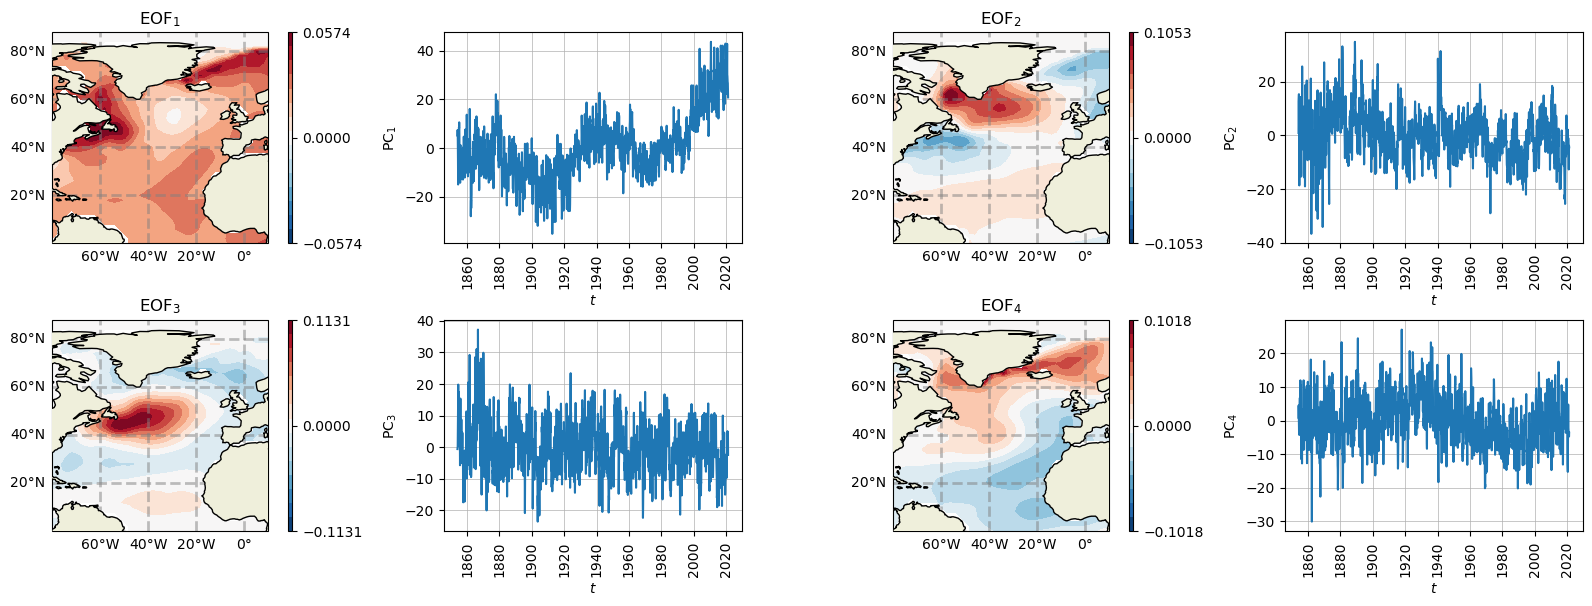

In [26]:
# plot a few EOFs out
pcarree = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 6))
for k in range(4):

    # pull out the plots and set the
    EOF = EOFs[k, :, :]
    limit = np.nanmax(np.nanmax(np.abs(EOF)))
    levels = np.linspace(-limit, limit, 16)

    ax = plt.subplot(2, 4, 2*k+1, projection=pcarree)
    cs = ax.contourf(lon, lat, EOF, cmap="RdBu_r", levels=levels)
    gl = ax.gridlines(crs=pcarree, draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.add_feature(cartopy.feature.LAND, zorder = 10, edgecolor = 'k')
    ax.set_title(f"$\mathrm{{EOF}}_{k+1}$")

    divider = make_axes_locatable(ax)  # add a colorbar
    cb_ax = divider.append_axes("right", size = "2%", pad = 0.2, axes_class=plt.Axes)
    cax = plt.colorbar(cs, cax=cb_ax)
    cax.set_ticks([-limit, 0, limit])

    ax = plt.subplot(2, 4, 2*k+2)
    ax.plot(time, PCs[:, k], color="C0")
    ax.set_xlabel(f"$t$")
    ax.set_ylabel(f"$\mathrm{{PC}}_{k+1}$")
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
        'rotation', 90)
    ax.grid(lw=0.5, zorder=0)

fig.tight_layout(pad=0.5)

With regards to interpretations, I am going to speculate a bit here, and I am willing to be shown wrong in my interpretations.

### EOF 1

I would have initially thought this would correspond to the global warming signal (partly given that the PCs are increasing over time) since I am almost certain that the anomalies are not relative to the linear trend over the whole period so that the global warming signal has not been removed, but it probably also includes the [**Atlantic Multi-decadal Variability (AMV)**](https://en.wikipedia.org/wiki/Atlantic_multidecadal_oscillation), which is a long-time scale variability on the order of 40 or so years probably (a quick look at the power spectrum suggests there is a peak at 60 years).

### EOF 2

This one is probably related to the [**North Atlantic Oscillation**](https://en.wikipedia.org/wiki/North_Atlantic_oscillation), with the sandwich pattern with the filling just south of Greenland, sandwiched between the blobs Gulf Stream region and North East of Iceland (very technical language here).

### EOF 3

Apart from this looking like the EOF 2 in Figure 3 of [Buckley et al. (2014)](https://www.researchgate.net/publication/277677765_Low-Frequency_SST_and_Upper-Ocean_Heat_Content_Variability_in_the_North_Atlantic/figures?lo=1), I don't have much more to add...

### EOF 4

No idea. This one seems to have a long period, so may also be related somewhat to AMV.

> NOTE: This stuff is probably also highlighting that there are a few things one might need to do as pre/post-processing to get more information. These would include:
>
> 1) taking the global warming trend out, which would modify the EOF analysis probably (pre-processing)
>
> 2) might want to also take the seasonal cycle out via averaging over a few months (pre/post-processing)
>
> 3) window the PCs a bit to make the time-series analysis a bit clearer (post-processing)

> <span style="color:red">**Q.**</span> Do a time-series analysis on the PCs, picking out periods and the like.

> <span style="color:red">**Q.**</span> Try doing some of the things I suggested above.

> <span style="color:red">**Q.**</span> (coding) I am sure there are better ways to write the code that I did above, particularly with making better use of the xarray functionalities. Try and improve on my code (let me know if you do if you are happy to share).

> <span style="color:red">**Q.**</span> (coding) Try replacing my indexing procedure to get wet points with using the masked array functionality.

> <span style="color:red">**Q.**</span> (exploratory) Try different spatial regions. The equatorial Pacific is a particularly interesting region.

----------------
# More involved exercises with this notebook

## 1) Spectral analysis for GEBCO bathymetry data

Consider trying the Fourier analyses things on GEBCO data. Some things to bear in mind and think about:

1) why might it not be valid to do a Fourier analysis with the global GEBCO data?

2) if you do an analysis over a large region, you may want to adjust your conversion from lon/lat degrees to (kilo)meters from the one I used, because the assumption of 1 degree = 100 km then is even more dodgy, since the conversion is a function of latitude

3) consider doing the analyses in patches, and see if there is some robustness in the power spectrum (e.g. [Goff & Jordan, 1989](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/GL016i001p00045))

<img src="https://i.imgur.com/bvclGhT.jpg" width="600" alt='picture of patches'>

(a picture of the (in)famous Patches)

4) consider doing the ocean and land parts separately

5) [pretty involved] the proper thing to do is probably something like a **spherical harmonic analysis**, but you will probably need to go beyond native `numpy` and `scipy` packages

## 2) [Probably quite involved] Spilhaus projection

Work out how you might make the [Spilhaus projection](https://storymaps.arcgis.com/stories/756bcae18d304a1eac140f19f4d5cb3d) in Python:

<img src="https://www.researchgate.net/profile/Michael-Meredith-5/publication/334126444/figure/fig2/AS:775590957309952@1561926702371/The-globe-viewed-on-a-Spilhaus-projection-in-contrast-to-conventional-projections-this_W640.jpg" width="400" alt='spilhaus'>

(Cursed projection? Figure from Mike Meredith.)

There is some work being done on the Cartopy repository itself with sporadic activity. If you get this working, I would suggest you make a pull request for Cartopy, because that would certainly be an addition I'd like to see in Cartopy (I think the above is made is a GIS software).

## c) Analysis of `current_speed.nc`

Try the EOF analysis for the `current_speed.nc` data and see if anything interesting comes out. There should be no land points. Try also doing some time series analysis on the resulting PCs (e.g. Fourier analysis, suitably averaged etc.)

## d) EOFs by hand

Try doing EOFs by hand. The command you probably want is `np.linalg.svd(X, full_matrices=False)` (the last optional keyword means you don't save the singular values as a diagonal matrix).

You can also try using EOFs for time-series analysis.